In [1]:
from google.colab import drive
drive.mount('/content/gdrive')


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [2]:
test_path = 'gdrive/My Drive/chest_xray/test'  #change dir to your project folder

In [3]:
train_path = 'gdrive/My Drive/chest_xray/train'

In [4]:
import os
os.listdir('/')

['dev',
 'root',
 'lib',
 'tmp',
 'mnt',
 'sbin',
 'srv',
 'opt',
 'media',
 'proc',
 'usr',
 'boot',
 'var',
 'home',
 'lib64',
 'sys',
 'bin',
 'etc',
 'run',
 'content',
 '.dockerenv',
 'tools',
 'datalab',
 'swift',
 'dlib-19.18.0-cp27-cp27mu-linux_x86_64.whl',
 'tensorflow-1.15.2',
 'dlib-19.18.0-cp36-cp36m-linux_x86_64.whl',
 'lib32']

In [5]:
## Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
#print(os.listdir("../input"))

import random
import warnings
from sklearn.metrics import confusion_matrix
warnings.filterwarnings('ignore')

#File Operation libraries
import glob
from pathlib import Path

#Visualisation Libraries
import matplotlib.pyplot as plt
import seaborn as sns
from mlxtend.plotting import plot_confusion_matrix

#Keras
from keras.layers import Dense, Conv2D, MaxPooling2D, AvgPool2D, Input, Dropout, Flatten, BatchNormalization
from keras.models import Sequential, Model
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg19 import VGG19

#Image Transformation Libraries
import cv2
from imgaug import augmenters as iaa

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
#print(os.listdir("../input"))

from os import listdir, makedirs
from os.path import join, exists, expanduser

from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.models import Sequential, Model, load_model
from keras.layers import Dense, GlobalAveragePooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras import backend as K
import tensorflow as tf
from keras.utils.data_utils import Sequence
import sys
from PIL import *
sys.modules['Image'] = Image 
# Any results you write to the current directory are saved as output.



Using TensorFlow backend.


In [6]:
base_dir='gdrive/My Drive/chest_xray'

In [7]:
train_data = base_dir+'/train/'
test_data = base_dir+'/test/'
val_data = base_dir+'/val/'

In [8]:
train_data

'gdrive/My Drive/chest_xray/train/'

In [9]:
image_size = (180, 180)
batch_size = 32

In [10]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
data_augmentation = tf.keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomRotation(0.1),
    ]
)

In [11]:
from keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1. / 255)
val_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_directory(
    train_data,
    target_size=(180, 180),
    batch_size=32,
    class_mode='categorical')

test_generator = test_datagen.flow_from_directory(
    test_data,
    target_size=(180, 180),
    batch_size=32,
    class_mode='categorical')

validation_generator = val_datagen.flow_from_directory(
    val_data,
    target_size=(180, 180),
    batch_size=32,
    class_mode='categorical')

Found 5218 images belonging to 2 classes.
Found 631 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


In [12]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    x = data_augmentation(inputs)

    # Entry block
    x = layers.experimental.preprocessing.Rescaling(1.0 / 255)(x)
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [128, 256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)

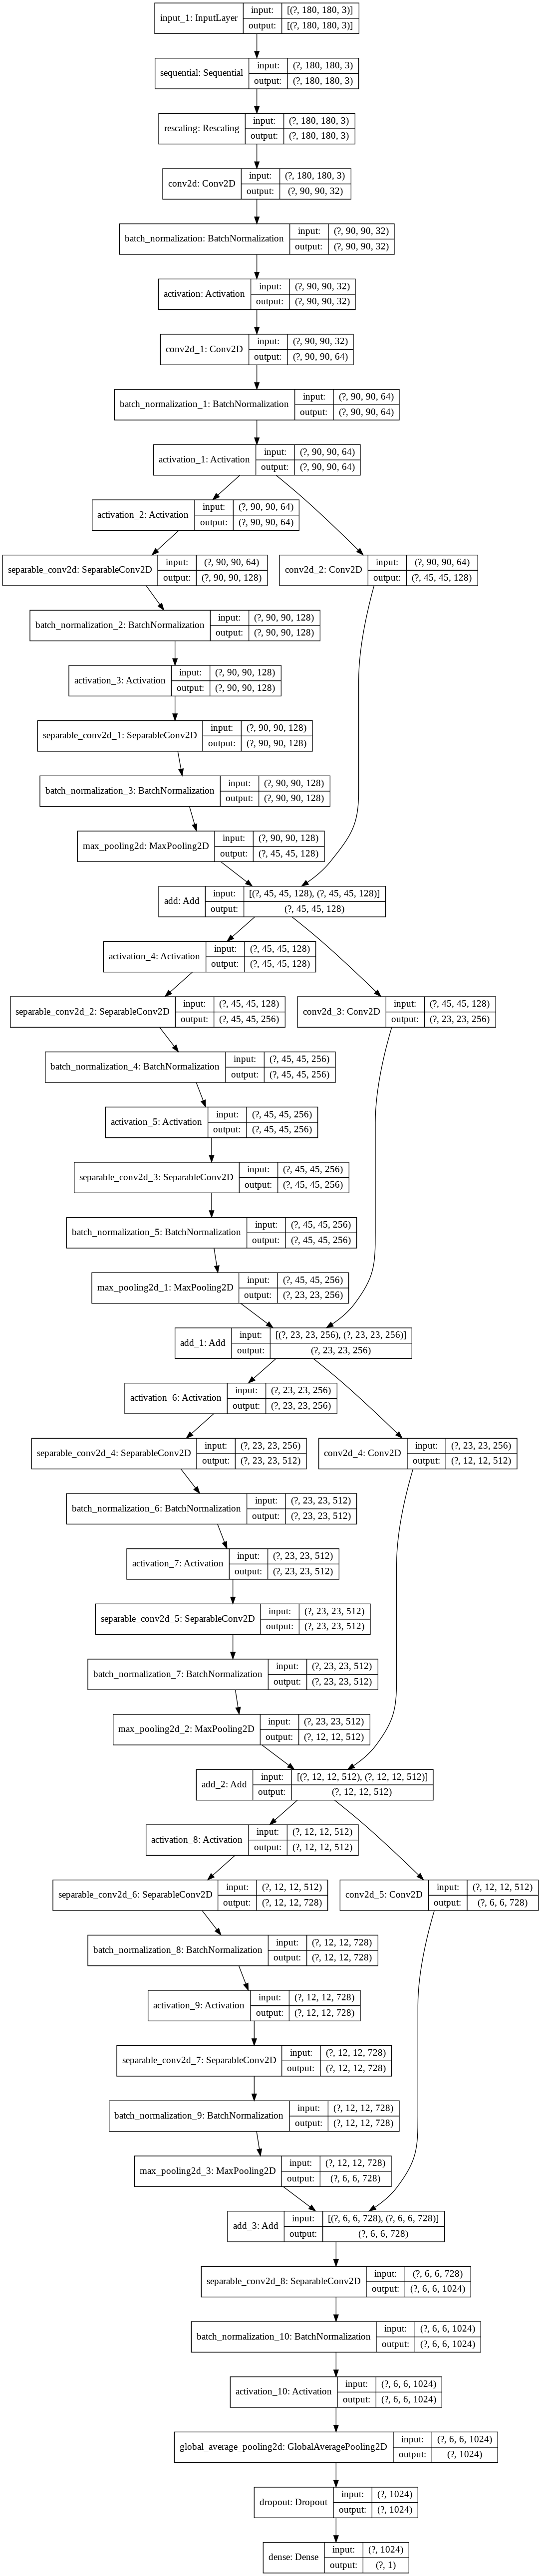

In [13]:
model = make_model(input_shape=image_size + (3,), num_classes=2)
keras.utils.plot_model(model, show_shapes=True)

In [14]:
epochs = 1

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5"),
]
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
model.fit(
    train_generator, epochs=epochs, callbacks=callbacks, validation_data=test_generator,
)

164/164 [==============================] - 1641s 10s/step - loss: 0.7172 - accuracy: 0.5000 - val_loss: 0.6933 - val_accuracy: 0.5000


In [15]:
img = keras.preprocessing.image.load_img(
    "./chest_xray/test/PNEUMONIA/person1_virus_7.jpeg", target_size=image_size
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
score = predictions[0]
print(score)
print(
    "This image is %.2f percent NORMAL and %.2f percent PNEUMONIA."
    % (100 * (1 - score), 100 * score)
)


FileNotFoundError: ignored

In [ ]:
#import inception with pre-trained weights. do not include fully #connected layers
from keras.applications.resnet50 import ResNet50
model = ResNet50(weights='imagenet', include_top=False)

In [ ]:
result = model.output
result = GlobalAveragePooling2D()(result)
# add a fully-connected layer
result = Dense(512, activation='relu')(result)
# and a fully connected output/classification layer
predictions = Dense(2, activation='sigmoid')(result)

In [ ]:
inception_transfer = Model(inputs=model.input, outputs=predictions)


In [ ]:
inception_transfer.compile(loss='categorical_crossentropy',
              optimizer=optimizers.SGD(lr=1e-4, momentum=0.9),
              metrics=['accuracy'])

In [ ]:
import tensorflow as tf
with tf.device("/device:GPU:0"):
    history_pretrained = inception_transfer.fit_generator(
    train_generator,
    epochs=10, shuffle = True, verbose = 1, validation_data = test_generator)

In [ ]:
import matplotlib.pyplot as plt
# summarize history for accuracy
plt.plot(history_pretrained.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Pretrained'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history_pretrained.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Pretrained'], loc='upper left')
plt.show()

In [ ]:
from keras.applications.vgg16 import VGG16
model = VGG16(weights='imagenet', include_top=False)
result = model.output
result = GlobalAveragePooling2D()(result)
# add a fully-connected layer
result = Dense(512, activation='relu')(result)
# and a fully connected output/classification layer
predictions = Dense(2, activation='sigmoid')(result)
inception_transfer = Model(inputs=model.input, outputs=predictions)
inception_transfer.compile(loss='categorical_crossentropy',
              optimizer=optimizers.SGD(lr=1e-4, momentum=0.9),
              metrics=['accuracy'])
import tensorflow as tf
with tf.device("/device:GPU:0"):
    history_pretrained = inception_transfer.fit_generator(
    train_generator,
    epochs=10, shuffle = True, verbose = 1, validation_data = test_generator)

In [ ]:
import matplotlib.pyplot as plt
# summarize history for accuracy
plt.plot(history_pretrained.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Pretrained'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history_pretrained.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Pretrained'], loc='upper left')
plt.show()

In [ ]:
scores = inception_transfer.evaluate_generator(test_generator)
print('acc =',scores[1]*100)